In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
import librosa
import librosa.display

## Extract Spectrograms

In [2]:

AUDIO_DIR = "/kaggle/input/manns-planet/Audio_Data/train"
OUTPUT_DIR = "/kaggle/working/spectrograms"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Function to create and save mel spectrogram
def save_mel_spectrogram(audio_path, save_path, sr=22050, n_mels=128, n_fft=2048, hop_length=512):
    try:
        y, sr = librosa.load(audio_path, sr=sr, mono=True)  # Load audio
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB

        # Save as image
        plt.figure(figsize=(5, 5))
        librosa.display.specshow(mel_spec_db, sr=sr, hop_length=hop_length, cmap="magma")
        plt.axis("off")
        plt.savefig(save_path, bbox_inches="tight", pad_inches=0)
        plt.close()
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")

# Process all class folders
for class_name in os.listdir(AUDIO_DIR):
    class_path = os.path.join(AUDIO_DIR, class_name)
    
    if os.path.isdir(class_path):
        class_output_path = os.path.join(OUTPUT_DIR, class_name)
        os.makedirs(class_output_path, exist_ok=True)

        for filename in os.listdir(class_path):
            if filename.endswith(".wav"):
                audio_file = os.path.join(class_path, filename)
                save_path = os.path.join(class_output_path, filename.replace(".wav", ".png"))
                save_mel_spectrogram(audio_file, save_path)

print("Spectrograms saved for all classes!")


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


Spectrograms saved for all classes!


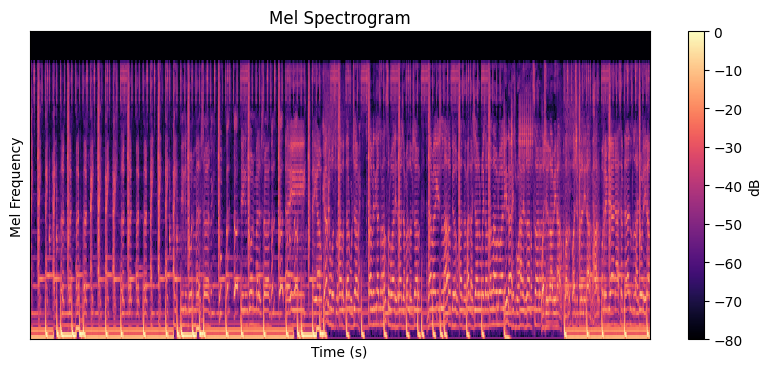

In [3]:
# Load the audio file
audio_path = "/kaggle/input/manns-planet/Audio_Data/train/aegir_27/aegir_27_0.wav"
y, sr = librosa.load(audio_path, sr=22050, mono=True)

# Compute Mel spectrogram
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=512)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Plot spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db, sr=sr, hop_length=512, cmap="magma")
plt.colorbar(label="dB")
plt.title("Mel Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Mel Frequency")
plt.show()


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define dataset path
DATASET_PATH = "/kaggle/working/spectrograms"  # The original dataset folder
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Load dataset with 80% train, 20% validation split
train_dataset = image_dataset_from_directory(
    DATASET_PATH,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # 20% for validation
    subset="training",  # Get training subset
    seed=42  # Fix randomness for reproducibility
)

val_dataset = image_dataset_from_directory(
    DATASET_PATH,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # 20% for validation
    subset="validation",  # Get validation subset
    seed=42
)

# Check class names
class_names = train_dataset.class_names
print("Classes:", class_names)


Found 480 files belonging to 6 classes.
Using 384 files for training.
Found 480 files belonging to 6 classes.
Using 96 files for validation.
Classes: ['aegir_27', 'solmara_vi', 'strathea_iv', 'veyrah_theta', 'xyphos_1', 'zephyrion_9']


In [6]:
# Normalize pixel values (scale between 0 and 1)
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Improve performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

## CNN Model to train on Spectrograms

In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def build_deep_cnn(input_shape, num_classes):
    model = models.Sequential([
        # Conv Block 1
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv Block 2
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv Block 3
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Conv Block 4
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Fully Connected Layers
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile Model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Model Summary
model = build_deep_cnn((128, 128, 3), 6)
model.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)                   │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_46               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 4,958,790 (18.92 MB)

 Trainable params: 4,954,950 (18.90 MB)

 Non-trainable params: 3,840 (15.00 KB)

Epoch 1/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.2337 - loss: 4.3837 - val_accuracy: 0.1875 - val_loss: 5134.2739 - learning_rate: 0.0050
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.2965 - loss: 2.4749 - val_accuracy: 0.1562 - val_loss: 637.7970 - learning_rate: 0.0050
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.3040 - loss: 2.3863 - val_accuracy: 0.1458 - val_loss: 61.8382 - learning_rate: 0.0050
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.3792 - loss: 2.0506 - val_accuracy: 0.1875 - val_loss: 27.3086 - learning_rate: 0.0050
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.3869 - loss: 2.0690 - val_accuracy: 0.1875 - val_loss: 25.8138 - learning_rate: 0.0050
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.3673 - loss: 1.9684 - val_accuracy: 0.2917 - val_loss: 9.8317 - learning_rate: 0.0050
Epoch 7/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.4583 - loss: 

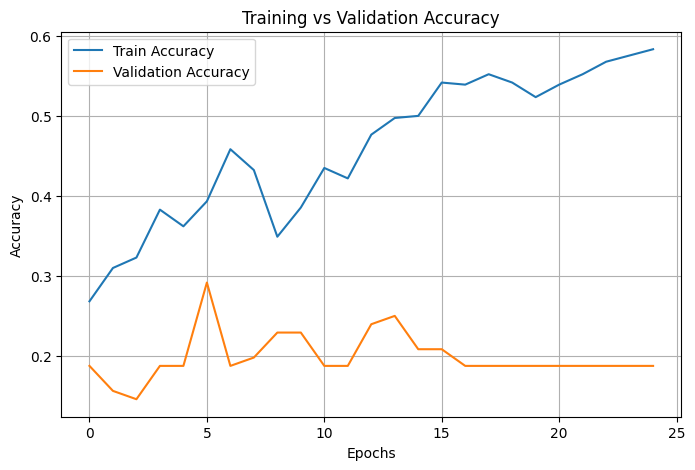

In [36]:
import matplotlib.pyplot as plt

# Train the model
EPOCHS = 25

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
]
)

# Plot Training & Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


# Feature Extraction + Classical ML

### Extracting MFCC, Chroma and Spectral Contrast

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Path to dataset
AUDIO_DIR = "/kaggle/input/manns-planet/Audio_Data/train"

# Function to extract features
def extract_features(file_path, sr=22050, n_mfcc=20):
    try:
        y, sr = librosa.load(file_path, sr=sr)

        if len(y) < 2048:  # Ensure minimum length for feature extraction
            return np.zeros(n_mfcc + 12 + 7)  # Adjusted feature size

        # MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)

        # Chroma Features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)

        # Spectral Contrast
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        spectral_contrast_mean = np.mean(spectral_contrast, axis=1)

        # Ensure all features have a fixed size
        return np.hstack([mfcc_mean, chroma_mean, spectral_contrast_mean])

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros(n_mfcc + 12 + 7)  # Return fixed-size zero vector on failure

# Extract features
X, y = [], []
label_dict = {label: i for i, label in enumerate(os.listdir(AUDIO_DIR))}  # Assign numeric labels

for label in os.listdir(AUDIO_DIR):
    label_path = os.path.join(AUDIO_DIR, label)
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            if file.endswith(".wav"):
                file_path = os.path.join(label_path, file)
                features = extract_features(file_path)
                X.append(features)
                y.append(label_dict[label])

# Convert to NumPy array
X = np.array(X, dtype=np.float32)
y = np.array(y)

# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [4]:
X

array([[-2.508423  , -0.08871437,  0.8465752 , ...,  0.6233125 ,
         0.1595015 , -0.04410348],
       [ 1.5242653 ,  0.93192005,  0.35310733, ...,  0.24030094,
         0.17240956,  0.08603168],
       [ 0.14516267,  0.03384285, -0.02555617, ..., -0.05319794,
         0.21821298, -0.00992063],
       ...,
       [-1.445715  ,  0.99423116,  0.8251596 , ...,  0.5745568 ,
         0.7669604 , -0.24951676],
       [ 0.43797117,  0.35639536,  0.7641046 , ..., -0.5451524 ,
        -0.41316247,  0.16629346],
       [-0.29506847,  0.571385  ,  1.4866995 , ...,  0.04053242,
        -0.08382975, -0.15764418]], dtype=float32)

In [5]:
# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Train a RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.89      0.77      0.83        22
           1       0.73      0.92      0.81        12
           2       0.93      1.00      0.96        13
           3       0.81      0.93      0.87        14
           4       0.79      0.69      0.73        16
           5       0.89      0.84      0.86        19

    accuracy                           0.84        96
   macro avg       0.84      0.86      0.85        96
weighted avg       0.85      0.84      0.84        96



In [7]:
print(label_dict)

{'zephyrion_9': 0, 'solmara_vi': 1, 'veyrah_theta': 2, 'strathea_iv': 3, 'xyphos_1': 4, 'aegir_27': 5}


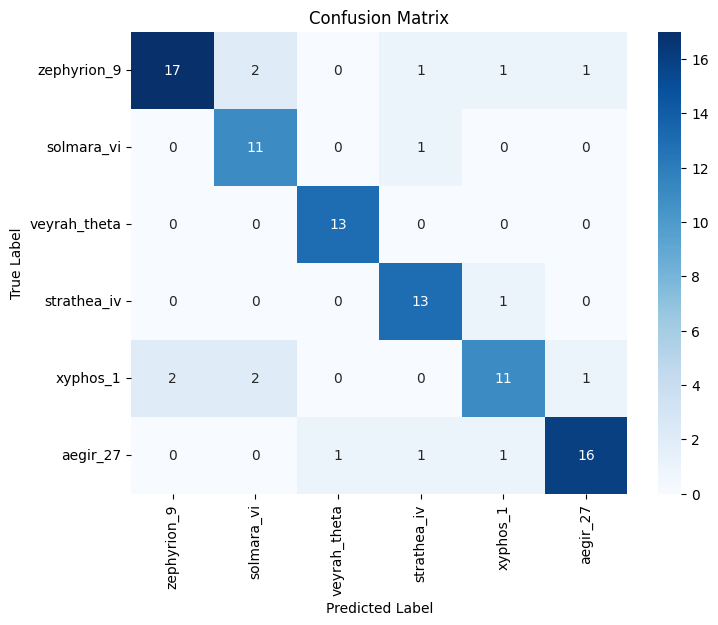

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict on test data
y_pred = model.predict(X_val)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)
class_names = list(label_dict.keys())  # Get class names

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [11]:
from sklearn.ensemble import ExtraTreesClassifier

et_model = ExtraTreesClassifier(n_estimators=200, random_state=42)
et_model.fit(X_train, y_train)

y_pred = et_model.predict(X_val)
print("Extra Trees Accuracy:", accuracy_score(y_val, y_pred))

Extra Trees Accuracy: 0.8958333333333334


In [14]:
test_files = []
X_test_samples = []

TEST_DIR = "/kaggle/input/manns-planet/Audio_Data/test"

for file in os.listdir(TEST_DIR):
    if file.endswith(".wav"):
        file_path = os.path.join(TEST_DIR, file)
        features = extract_features(file_path)
        X_test_samples.append(features)
        test_files.append(file)  # Store filename

X_test_samples = np.array(X_test_samples)
X_test_samples = scaler.transform(X_test_samples)  # Use the same scaler

In [16]:
y_test_pred = et_model.predict(X_test_samples)

OUTPUT_CSV = "/kaggle/working/predictions.csv"

label_dict_inv = {v: k for k, v in label_dict.items()}
y_test_pred_labels = [label_dict_inv[pred] for pred in y_test_pred]

df = pd.DataFrame({'file_name': test_files, 'label': y_test_pred_labels})
df.to_csv(OUTPUT_CSV, index=False)
print("Predictions saved to:", OUTPUT_CSV)

Predictions saved to: /kaggle/working/predictions.csv


### Extracting MFCC (mean, std deviation, skew and kurtosis), Spectral centroid, bandwidth, contrast, RMSE, ZCR, Tonnetz

In [19]:
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

AUDIO_DIR = "/kaggle/input/manns-planet/Audio_Data/train"
TEST_DIR = "/kaggle/input/manns-planet/Audio_Data/test"
OUTPUT_CSV = "/kaggle/working/predictions.csv"

# Define enhanced feature sizes
N_MFCC = 20
N_CHROMA = 24  
N_CONTRAST = 12  

# Compute expected feature vector size
EXPECTED_FEATURE_SIZE = N_MFCC * 4 + N_CHROMA * 2 + N_CONTRAST * 2 + 6

def extract_features(file_path, sr=22050):
    try:
        y, sr = librosa.load(file_path, sr=sr)

        if len(y) < 2048:  # Ensure minimum length for feature extraction
            print(f"Skipping {file_path} due to short duration")
            return None
        
        # 1. Enhanced MFCC Features with Statistical Moments
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        mfcc_skew = scipy.stats.skew(mfcc, axis=1)
        mfcc_kurtosis = scipy.stats.kurtosis(mfcc, axis=1)
        
        # 2. Chroma Features
        chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_cqt_mean = np.mean(chroma_cqt, axis=1)
        chroma_stft_mean = np.mean(chroma_stft, axis=1)
        
        # 3. Spectral Features
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
        spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
        tonnetz_mean = np.mean(tonnetz, axis=1)
        
        # 4. Temporal and Spectral Characteristics
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y)[0][0]
        rms_energy = librosa.feature.rms(y=y)[0][0]

        # Compile features
        feature_vector = np.hstack([
            mfcc_mean, mfcc_std, mfcc_skew, mfcc_kurtosis,
            chroma_cqt_mean[:N_CHROMA], chroma_stft_mean[:N_CHROMA],
            spectral_contrast_mean[:N_CONTRAST], 
            tonnetz_mean[:N_CONTRAST],
            np.mean(onset_env),
            np.std(onset_env),
            zero_crossing_rate,
            rms_energy,
            np.mean(spectral_centroid),
            np.mean(spectral_bandwidth)
        ])
        
        # Pad if feature vector is shorter than expected
        if len(feature_vector) < EXPECTED_FEATURE_SIZE:
            feature_vector = np.pad(feature_vector, (0, EXPECTED_FEATURE_SIZE - len(feature_vector)))
        
        feature_vector = feature_vector[:EXPECTED_FEATURE_SIZE]

        return feature_vector
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None  # Skip problematic files

# Extract features from training data
X, y = [], []
label_dict = {label: i for i, label in enumerate(os.listdir(AUDIO_DIR))}  # Assign numeric labels

for label in os.listdir(AUDIO_DIR):
    label_path = os.path.join(AUDIO_DIR, label)
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            if file.endswith(".wav"):
                file_path = os.path.join(label_path, file)
                features = extract_features(file_path)
                if features is not None:  # Only append if extraction was successful
                    X.append(features)
                    y.append(label_dict[label])

# Convert to NumPy array
X = np.array(X, dtype=np.float32)
y = np.array(y)

print(f"Feature shape: {X.shape}, Labels shape: {y.shape}")

Skipping /kaggle/input/manns-planet/Audio_Data/train/strathea_iv/strathea_iv_71.wav due to short duration
Skipping /kaggle/input/manns-planet/Audio_Data/train/strathea_iv/strathea_iv_38.wav due to short duration
Skipping /kaggle/input/manns-planet/Audio_Data/train/strathea_iv/strathea_iv_34.wav due to short duration
Skipping /kaggle/input/manns-planet/Audio_Data/train/strathea_iv/strathea_iv_39.wav due to short duration
Skipping /kaggle/input/manns-planet/Audio_Data/train/strathea_iv/strathea_iv_42.wav due to short duration
Skipping /kaggle/input/manns-planet/Audio_Data/train/strathea_iv/strathea_iv_40.wav due to short duration
Skipping /kaggle/input/manns-planet/Audio_Data/train/strathea_iv/strathea_iv_41.wav due to short duration
Skipping /kaggle/input/manns-planet/Audio_Data/train/strathea_iv/strathea_iv_70.wav due to short duration
Skipping /kaggle/input/manns-planet/Audio_Data/train/strathea_iv/strathea_iv_35.wav due to short duration
Skipping /kaggle/input/manns-planet/Audio_Data

The audio files that were skipped here weren't used for training.

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [21]:
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train, y_train)

# Evaluate model
y_pred = clf.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Accuracy: 0.9680851063829787
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        16
           1       1.00      1.00      1.00        16
           2       0.94      0.94      0.94        16
           3       1.00      1.00      1.00        14
           4       1.00      0.88      0.93        16
           5       1.00      1.00      1.00        16

    accuracy                           0.97        94
   macro avg       0.97      0.97      0.97        94
weighted avg       0.97      0.97      0.97        94



In [124]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=100, gamma=0.01, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred_svm))
print(classification_report(y_val, y_pred_svm))

Accuracy: 0.875
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        16
           1       0.83      0.94      0.88        16
           2       0.88      0.88      0.88        16
           3       0.92      0.69      0.79        16
           4       0.83      0.94      0.88        16
           5       1.00      0.94      0.97        16

    accuracy                           0.88        96
   macro avg       0.88      0.88      0.87        96
weighted avg       0.88      0.88      0.87        96



In [8]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_estimators=300, random_state=42)
et.fit(X_train, y_train)
y_pred_et = et.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred_et))
print(classification_report(y_val, y_pred_et))

Accuracy: 0.9680851063829787
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       0.94      1.00      0.97        16
           2       1.00      0.94      0.97        16
           3       1.00      1.00      1.00        14
           4       1.00      0.88      0.93        16
           5       0.94      1.00      0.97        16

    accuracy                           0.97        94
   macro avg       0.97      0.97      0.97        94
weighted avg       0.97      0.97      0.97        94



In [9]:
test_files = []
X_test_samples = []

for file in os.listdir(TEST_DIR):
    if file.endswith(".wav"):
        file_path = os.path.join(TEST_DIR, file)
        features = extract_features(file_path)
        X_test_samples.append(features)
        test_files.append(file)  # Store filename

X_test_samples = np.array(X_test_samples)
X_test_samples = scaler.transform(X_test_samples)  # Use the same scaler


Skipping /kaggle/input/manns-planet/Audio_Data/test/sample_039.wav due to short duration
Skipping /kaggle/input/manns-planet/Audio_Data/test/sample_021.wav due to short duration


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (120,) + inhomogeneous part.

In [11]:
print(len(X_test_samples))

120


Skipping the 2 samples and predicting classes for the rest. The 2 samples were manually assigned random classes.

In [14]:
test_files = []
X_test_samples = []

for file in os.listdir(TEST_DIR):
    if file.endswith(".wav"):
        file_path = os.path.join(TEST_DIR, file)
        features = extract_features(file_path)
        
        # ✅ Skip invalid feature vectors
        if features is not None and len(features) == EXPECTED_FEATURE_SIZE:
            X_test_samples.append(features)
            test_files.append(file)
        else:
            print(f"Skipping file {file} due to inconsistent features.")

# Convert test data safely
if len(X_test_samples) > 0:
    X_test_samples = np.array(X_test_samples, dtype=np.float32)
    X_test_samples = scaler.transform(X_test_samples)

    # Predict on valid samples only
    y_test_pred = clf.predict(X_test_samples)

    # Convert predictions back to labels
    label_dict_inv = {v: k for k, v in label_dict.items()}
    y_test_pred_labels = [label_dict_inv[pred] for pred in y_test_pred]

    # Save predictions
    df = pd.DataFrame({'file_name': test_files, 'label': y_test_pred_labels})
    df.to_csv(OUTPUT_CSV, index=False)
    print("Predictions saved to:", OUTPUT_CSV)
else:
    print("No valid test samples found.")


Skipping /kaggle/input/manns-planet/Audio_Data/test/sample_039.wav due to short duration
Skipping file sample_039.wav due to inconsistent features.
Skipping /kaggle/input/manns-planet/Audio_Data/test/sample_021.wav due to short duration
Skipping file sample_021.wav due to inconsistent features.
Predictions saved to: /kaggle/working/predictions.csv
